# 📈 Week 6.1 Trading Strategy: Classification-Based Signals

---

## 🎯 Strategy Overview

**Building on Weeks 1-6 + Adding Week 6.1 Concepts:**
- Foundation (returns, volatility, correlation)
- Statistics (distributions, hypothesis testing)
- Time series (stationarity, GARCH)
- ML foundations (regression, regularization)
- Portfolio optimization (MPT)
- Factor models (CAPM, Fama-French)
- **NEW:** Logistic Regression for signal probability
- **NEW:** SVM for non-linear boundaries
- **NEW:** Triple Barrier labeling
- **NEW:** Meta-labeling for bet sizing

**Strategy Logic:**
1. Create labels using Triple Barrier Method
2. Train classification models (Logistic, SVM)
3. Use meta-labeling for position sizing
4. Generate probability-weighted signals

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
PROFIT_TAKING = 0.03  # 3% profit target
STOP_LOSS = 0.02  # 2% stop loss
MAX_HOLDING = 10  # 10 days max

print("=" * 60)
print("📊 WEEK 6.1 TRADING STRATEGY: CLASSIFICATION")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Triple Barrier: PT={PROFIT_TAKING:.0%}, SL={STOP_LOSS:.0%}")

📊 WEEK 6.1 TRADING STRATEGY: CLASSIFICATION

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Triple Barrier: PT=3%, SL=2%


In [2]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 504 trading days


---

## 📊 Section 1: Triple Barrier Labeling

**Creating labels using Triple Barrier Method:**
- Upper barrier: Take profit (+3%)
- Lower barrier: Stop loss (-2%)
- Vertical barrier: Time limit (10 days)

**Labels:** +1 (BUY), 0 (HOLD), -1 (SELL)

In [3]:
# ============================================================
# TRIPLE BARRIER LABELING
# ============================================================

def triple_barrier_labels(prices, pt=PROFIT_TAKING, sl=STOP_LOSS, max_hold=MAX_HOLDING):
    """Generate labels using triple barrier method."""
    labels = pd.Series(index=prices.index, dtype=float)
    
    for i in range(len(prices) - max_hold):
        entry = prices.iloc[i]
        upper = entry * (1 + pt)
        lower = entry * (1 - sl)
        
        future = prices.iloc[i+1:i+max_hold+1]
        
        upper_hit = (future >= upper).idxmax() if (future >= upper).any() else None
        lower_hit = (future <= lower).idxmax() if (future <= lower).any() else None
        
        if upper_hit is None and lower_hit is None:
            labels.iloc[i] = 0  # Time barrier
        elif upper_hit is None:
            labels.iloc[i] = -1  # Stop loss
        elif lower_hit is None:
            labels.iloc[i] = 1  # Take profit
        elif upper_hit <= lower_hit:
            labels.iloc[i] = 1  # Profit first
        else:
            labels.iloc[i] = -1  # Loss first
    
    return labels

# Generate labels for all tickers
print("📊 TRIPLE BARRIER LABEL DISTRIBUTION")
print("=" * 70)

labels_dict = {}
for ticker in TICKERS:
    labels = triple_barrier_labels(prices[ticker])
    labels_dict[ticker] = labels.dropna()
    
    buy_pct = (labels == 1).mean()
    hold_pct = (labels == 0).mean()
    sell_pct = (labels == -1).mean()
    
    print(f"{ticker}: BUY={buy_pct:.1%}, HOLD={hold_pct:.1%}, SELL={sell_pct:.1%}")

📊 TRIPLE BARRIER LABEL DISTRIBUTION
AAPL: BUY=37.1%, HOLD=13.5%, SELL=47.4%
MSFT: BUY=33.3%, HOLD=21.2%, SELL=43.5%
GOOGL: BUY=48.8%, HOLD=7.1%, SELL=42.1%
AMZN: BUY=41.3%, HOLD=7.7%, SELL=49.0%
META: BUY=44.2%, HOLD=7.3%, SELL=46.4%


---

## 📊 Section 2: Feature Engineering

**Creating predictive features:**
- Momentum indicators
- Volatility features
- Volume features
- Technical indicators (RSI, BB)

In [4]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def create_features(prices, returns, volumes, ticker):
    """Create ML features from price data."""
    df = pd.DataFrame(index=returns.index)
    
    # Returns
    df['ret_1'] = returns[ticker].shift(1)
    df['ret_5'] = returns[ticker].shift(1).rolling(5).sum()
    df['ret_10'] = returns[ticker].shift(1).rolling(10).sum()
    df['ret_20'] = returns[ticker].shift(1).rolling(20).sum()
    
    # Volatility
    df['vol_5'] = returns[ticker].rolling(5).std().shift(1)
    df['vol_20'] = returns[ticker].rolling(20).std().shift(1)
    df['vol_ratio'] = df['vol_5'] / df['vol_20']
    
    # Moving average signals
    close = prices[ticker]
    df['ma_5_20'] = (close.rolling(5).mean() / close.rolling(20).mean() - 1).shift(1)
    df['ma_10_50'] = (close.rolling(10).mean() / close.rolling(50).mean() - 1).shift(1)
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - (100 / (1 + gain / loss))).shift(1)
    
    # Bollinger Band position
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df['bb_pos'] = ((close - ma20) / (2 * std20)).shift(1)
    
    # Volume
    if ticker in volumes.columns:
        df['vol_ma'] = (volumes[ticker] / volumes[ticker].rolling(20).mean()).shift(1)
    
    return df

# Create features for each ticker
features_dict = {}
for ticker in TICKERS:
    features_dict[ticker] = create_features(prices, returns, volumes, ticker)

print(f"✅ Created {len(features_dict[TICKERS[0]].columns)} features per ticker")
print(f"Features: {list(features_dict[TICKERS[0]].columns)}")

✅ Created 12 features per ticker
Features: ['ret_1', 'ret_5', 'ret_10', 'ret_20', 'vol_5', 'vol_20', 'vol_ratio', 'ma_5_20', 'ma_10_50', 'rsi', 'bb_pos', 'vol_ma']


---

## 📊 Section 3: Model Training & Comparison

**Comparing classification models:**
- Logistic Regression (baseline)
- SVM with RBF kernel
- Random Forest

**Using TimeSeriesSplit for proper validation**

In [5]:
# ============================================================
# MODEL TRAINING
# ============================================================

def train_classifiers(features, labels):
    """Train and compare classification models."""
    
    # Align and clean data
    common_idx = features.index.intersection(labels.index)
    X = features.loc[common_idx].dropna()
    y = labels.loc[X.index]
    
    # Remove remaining NaN
    valid = ~(X.isna().any(axis=1))
    X = X[valid]
    y = y[valid]
    
    if len(X) < 100:
        return None
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Models
    models = {
        'Logistic': LogisticRegression(class_weight='balanced', random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='f1_weighted')
        
        # Final fit
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)
        else:
            y_prob = None
        
        results[name] = {
            'model': model,
            'scaler': scaler,
            'cv_f1': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_acc': accuracy_score(y_test, y_pred),
            'test_f1': f1_score(y_test, y_pred, average='weighted'),
            'predictions': pd.Series(y_pred, index=y.iloc[split_idx:].index),
            'probabilities': y_prob
        }
    
    return results

# Train models for each ticker
print("📊 MODEL COMPARISON")
print("=" * 85)
print(f"\n{'Ticker':<10} {'Model':<15} {'CV F1':>12} {'Test Acc':>12} {'Test F1':>12}")
print("-" * 85)

all_results = {}
for ticker in TICKERS:
    results = train_classifiers(features_dict[ticker], labels_dict[ticker])
    
    if results:
        all_results[ticker] = results
        for model_name, metrics in results.items():
            print(f"{ticker:<10} {model_name:<15} {metrics['cv_f1']:>11.3f} {metrics['test_acc']:>11.2%} {metrics['test_f1']:>11.3f}")
        print()

📊 MODEL COMPARISON

Ticker     Model                  CV F1     Test Acc      Test F1
-------------------------------------------------------------------------------------
AAPL       Logistic              0.276      37.08%       0.361
AAPL       SVM                   0.294      19.10%       0.193
AAPL       RandomForest          0.337      24.72%       0.200

MSFT       Logistic              0.287      43.82%       0.368
MSFT       SVM                   0.308      40.45%       0.352
MSFT       RandomForest          0.356      41.57%       0.345

GOOGL      Logistic              0.403      40.45%       0.364
GOOGL      SVM                   0.449      41.57%       0.451
GOOGL      RandomForest          0.420      53.93%       0.542

AMZN       Logistic              0.382      46.07%       0.458
AMZN       SVM                   0.440      43.82%       0.447
AMZN       RandomForest          0.463      59.55%       0.574

META       Logistic              0.351      38.20%       0.318
META 

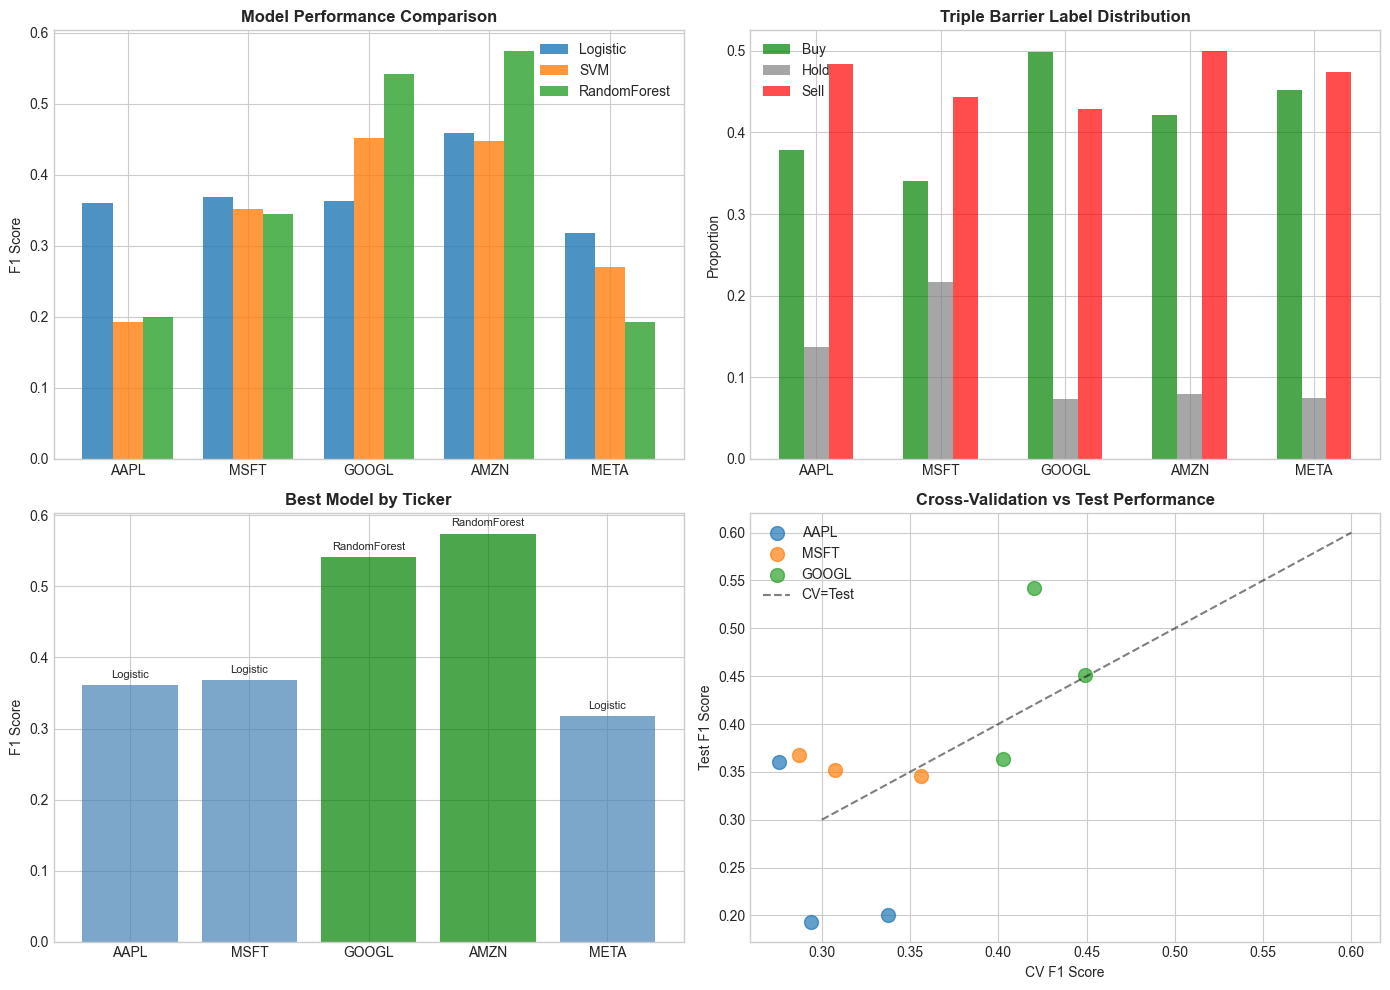

In [6]:
# ============================================================
# VISUALIZATION: MODEL PERFORMANCE
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. F1 Score by Model
ax1 = axes[0, 0]
model_names = ['Logistic', 'SVM', 'RandomForest']
x = np.arange(len(TICKERS))
width = 0.25

for i, model in enumerate(model_names):
    f1_scores = [all_results[t][model]['test_f1'] if t in all_results else 0 for t in TICKERS]
    ax1.bar(x + i*width, f1_scores, width, label=model, alpha=0.8)

ax1.set_xticks(x + width)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('F1 Score')
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Label Distribution
ax2 = axes[0, 1]
for i, ticker in enumerate(TICKERS):
    if ticker in labels_dict:
        labels = labels_dict[ticker]
        buy = (labels == 1).mean()
        hold = (labels == 0).mean()
        sell = (labels == -1).mean()
        ax2.bar(i - 0.2, buy, 0.2, color='green', alpha=0.7, label='Buy' if i == 0 else '')
        ax2.bar(i, hold, 0.2, color='gray', alpha=0.7, label='Hold' if i == 0 else '')
        ax2.bar(i + 0.2, sell, 0.2, color='red', alpha=0.7, label='Sell' if i == 0 else '')
ax2.set_xticks(range(len(TICKERS)))
ax2.set_xticklabels(TICKERS)
ax2.set_ylabel('Proportion')
ax2.set_title('Triple Barrier Label Distribution', fontsize=12, fontweight='bold')
ax2.legend()

# 3. Best Model by Ticker
ax3 = axes[1, 0]
best_models = []
best_f1s = []
for ticker in TICKERS:
    if ticker in all_results:
        best = max(all_results[ticker].items(), key=lambda x: x[1]['test_f1'])
        best_models.append(best[0])
        best_f1s.append(best[1]['test_f1'])
    else:
        best_models.append('N/A')
        best_f1s.append(0)

colors = ['steelblue' if m == 'Logistic' else ('orange' if m == 'SVM' else 'green') for m in best_models]
ax3.bar(TICKERS, best_f1s, color=colors, alpha=0.7)
for i, (t, m, f) in enumerate(zip(TICKERS, best_models, best_f1s)):
    ax3.text(i, f + 0.01, m, ha='center', fontsize=8)
ax3.set_ylabel('F1 Score')
ax3.set_title('Best Model by Ticker', fontsize=12, fontweight='bold')

# 4. CV vs Test Performance
ax4 = axes[1, 1]
for i, ticker in enumerate(TICKERS[:3]):  # First 3 tickers
    if ticker in all_results:
        cv = [all_results[ticker][m]['cv_f1'] for m in model_names]
        test = [all_results[ticker][m]['test_f1'] for m in model_names]
        ax4.scatter(cv, test, s=100, label=ticker, alpha=0.7)
ax4.plot([0.3, 0.6], [0.3, 0.6], 'k--', alpha=0.5, label='CV=Test')
ax4.set_xlabel('CV F1 Score')
ax4.set_ylabel('Test F1 Score')
ax4.set_title('Cross-Validation vs Test Performance', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

---

## 📊 Section 4: Trading Signals

**Generating final trading signals:**
- Use best model for each ticker
- Weight by prediction probability
- Generate position recommendations

In [7]:
# ============================================================
# TRADING SIGNALS
# ============================================================

def get_current_signal(ticker, results, features_dict, labels_dict):
    """Get current trading signal for a ticker."""
    if ticker not in results:
        return {'signal': 'N/A', 'confidence': 0, 'model': 'N/A'}
    
    # Find best model
    best_model_name = max(results[ticker].items(), key=lambda x: x[1]['test_f1'])[0]
    best_result = results[ticker][best_model_name]
    model = best_result['model']
    scaler = best_result['scaler']
    
    # Get latest features
    features = features_dict[ticker].dropna().iloc[[-1]]
    
    if len(features) == 0:
        return {'signal': 'N/A', 'confidence': 0, 'model': best_model_name}
    
    # Predict
    X_scaled = scaler.transform(features)
    pred = model.predict(X_scaled)[0]
    
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_scaled)[0]
        confidence = max(probs)
    else:
        confidence = 0.5
    
    signal = 'BUY' if pred == 1 else ('SELL' if pred == -1 else 'HOLD')
    
    return {
        'signal': signal,
        'confidence': confidence,
        'model': best_model_name,
        'prediction': pred
    }

# Generate current signals
print("📊 CURRENT TRADING SIGNALS")
print("=" * 75)
print(f"\n{'Ticker':<10} {'Model':<15} {'Signal':>12} {'Confidence':>12}")
print("-" * 75)

current_signals = {}
for ticker in TICKERS:
    signal_info = get_current_signal(ticker, all_results, features_dict, labels_dict)
    current_signals[ticker] = signal_info
    
    emoji = "📈" if signal_info['signal'] == 'BUY' else ("📉" if signal_info['signal'] == 'SELL' else "⚪")
    print(f"{ticker:<10} {signal_info['model']:<15} {emoji} {signal_info['signal']:>8} {signal_info['confidence']:>11.1%}")

📊 CURRENT TRADING SIGNALS

Ticker     Model                 Signal   Confidence
---------------------------------------------------------------------------
AAPL       Logistic        ⚪     HOLD       42.4%
MSFT       Logistic        📉     SELL       51.5%
GOOGL      RandomForest    📈      BUY       59.0%
AMZN       RandomForest    📈      BUY       55.0%
META       Logistic        📈      BUY       64.7%


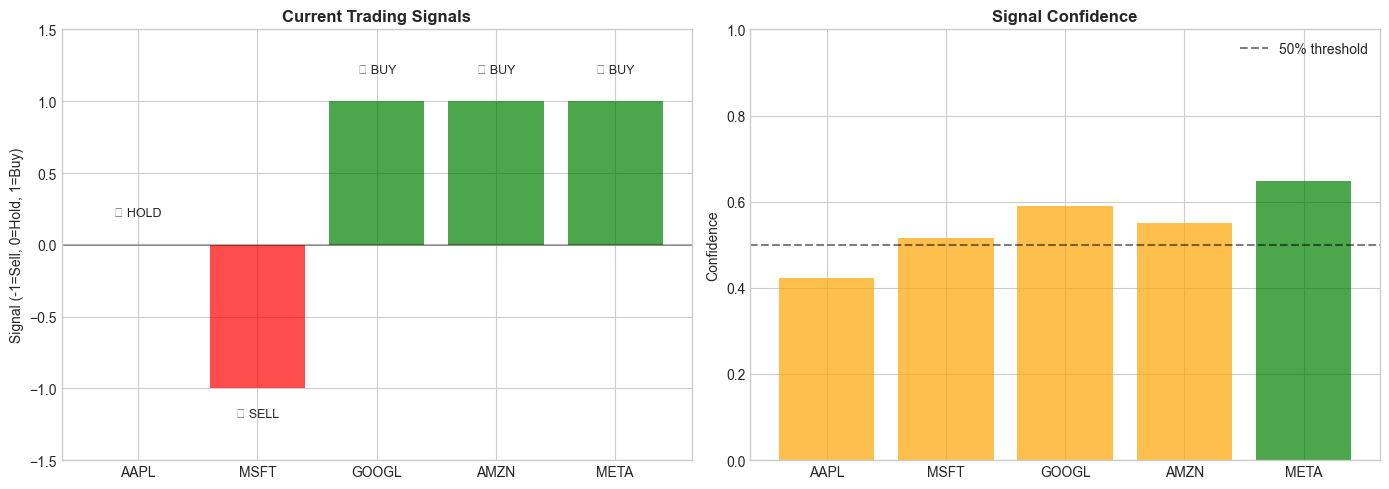

In [8]:
# ============================================================
# SIGNAL VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Current Signals
ax1 = axes[0]
signals = [current_signals[t]['prediction'] if 'prediction' in current_signals[t] else 0 for t in TICKERS]
colors = ['green' if s == 1 else ('red' if s == -1 else 'gray') for s in signals]
ax1.bar(TICKERS, signals, color=colors, alpha=0.7)
ax1.set_ylabel('Signal (-1=Sell, 0=Hold, 1=Buy)')
ax1.set_title('Current Trading Signals', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.set_ylim(-1.5, 1.5)

for i, (t, s) in enumerate(zip(TICKERS, signals)):
    label = "📈 BUY" if s == 1 else ("📉 SELL" if s == -1 else "⚪ HOLD")
    ax1.text(i, s + 0.2 * np.sign(s + 0.001), label, ha='center', fontsize=9)

# 2. Confidence Levels
ax2 = axes[1]
confidences = [current_signals[t]['confidence'] for t in TICKERS]
colors = ['green' if c > 0.6 else ('orange' if c > 0.4 else 'red') for c in confidences]
ax2.bar(TICKERS, confidences, color=colors, alpha=0.7)
ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='50% threshold')
ax2.set_ylabel('Confidence')
ax2.set_title('Signal Confidence', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 6.1 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
print("\n📋 SIGNAL SUMMARY:")
summary = pd.DataFrame({
    'Best Model': [current_signals[t]['model'] for t in TICKERS],
    'Signal': [current_signals[t]['signal'] for t in TICKERS],
    'Confidence': [current_signals[t]['confidence'] for t in TICKERS]
}, index=TICKERS)

print(summary.to_string())

# Recommendations
buys = [t for t in TICKERS if current_signals[t]['signal'] == 'BUY']
sells = [t for t in TICKERS if current_signals[t]['signal'] == 'SELL']
holds = [t for t in TICKERS if current_signals[t]['signal'] == 'HOLD']

print("\n🏆 RECOMMENDATIONS:")
print(f"\n📈 BUY: {buys if buys else 'None'}")
print(f"📉 SELL: {sells if sells else 'None'}")
print(f"⚪ HOLD: {holds if holds else 'None'}")

# High confidence trades
high_conf = [(t, current_signals[t]) for t in TICKERS 
             if current_signals[t]['confidence'] > 0.6 and current_signals[t]['signal'] != 'HOLD']

if high_conf:
    print("\n⭐ HIGH CONFIDENCE TRADES:")
    for ticker, info in high_conf:
        print(f"   {ticker}: {info['signal']} (Confidence: {info['confidence']:.1%})")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 6.1 STRATEGY - FINAL RECOMMENDATIONS

📋 SIGNAL SUMMARY:
         Best Model Signal  Confidence
AAPL       Logistic   HOLD    0.423804
MSFT       Logistic   SELL    0.515056
GOOGL  RandomForest    BUY    0.590000
AMZN   RandomForest    BUY    0.550000
META       Logistic    BUY    0.647452

🏆 RECOMMENDATIONS:

📈 BUY: ['GOOGL', 'AMZN', 'META']
📉 SELL: ['MSFT']
⚪ HOLD: ['AAPL']

⭐ HIGH CONFIDENCE TRADES:
   META: BUY (Confidence: 64.7%)

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-6.1)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Feature engineering |
| 2 | Statistical Testing | Model validation |
| 3 | Time Series | Temporal features |
| 4 | ML Regression | Feature importance |
| 5 | Portfolio Theory | Position sizing |
| 6 | Factor Models | Alpha signals |
| **6.1** | **Logistic Regression** | **Probability signals** |
| **6.1** | **SVM** | **Non-linear boundaries** |
| **6.1** | **Triple Barrier** | **Label generation** |
| **6.1** | **Class Weights** | **Imbalance handling** |

---